# Задача 1

In [49]:
%matplotlib inline
import numpy as np
import math as mt
import matplotlib
import matplotlib.pyplot as plt
from pylab import *
from scipy.stats import *
import pandas as pd
from numpy import linalg
from numpy.random import shuffle
from sklearn.metrics import mean_squared_error as msq

In [50]:
data = pd.read_csv('forestfires.csv').drop('day',1)

summer_set = ['jun','jul','aug']
data['month'] = [int(i in summer_set) for i in data['month']]
data['free_term'] = 1
data.head()

,X,Y,month,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,free_term
0,7,5,0,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0,1
1,7,4,0,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0,1
2,7,4,0,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0,1
3,8,6,0,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0,1
4,8,6,0,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0,1


In [51]:
x_headers = ['X', 'Y', 'month', 'FFMC', 'DMC', 'DC', 'ISI', 
             'temp', 'RH', 'wind', 'rain', 'free_term']
y_headers = ['area']

In [52]:
def Fit(data):
    X = data[x_headers]
    Y = data[y_headers]
    first = np.dot(X.T, X)
    second = np.dot(linalg.inv(first), X.T)
    return np.dot(second, Y)

def Split(data_old, k):
    # Перемешиваем
    data = data_old.reindex(np.random.permutation(data_old.index))
    assert k < 1., "k must be less than 1.0"
    train = data[:int(floor(k*len(data)))]
    test = data[int(floor(k*len(data))):]
    return train, test

def Predict(data, coefs):
    return np.dot(data, coefs)

def Train(data, k):
    train, test = Split(data, k)
    predictions = Predict(test[x_headers], Fit(train))
    return(msq(predictions, test[y_headers]))

In [53]:
print(Train(data, 0.7))

8030.14148518


Заменяю $area$ на $log(area + c)$

In [85]:
def LogError(data_old, k, c):
    data = data_old.copy()
    data[y_headers] = log(data[y_headers].values + c)
    return Train(data, k)

In [86]:
print(data.head())
LogError(data, 0.7, 10)

   X  Y  month  FFMC   DMC     DC  ISI  temp  RH  wind  rain  area  free_term
0  7  5      0  86.2  26.2   94.3  5.1   8.2  51   6.7   0.0   0.0          1
1  7  4      0  90.6  35.4  669.1  6.7  18.0  33   0.9   0.0   0.0          1
2  7  4      0  90.6  43.7  686.9  6.7  14.6  33   1.3   0.0   0.0          1
3  8  6      0  91.7  33.3   77.5  9.0   8.3  97   4.0   0.2   0.0          1
4  8  6      0  89.3  51.3  102.2  9.6  11.4  99   1.8   0.0   0.0          1


0.44859979033280184

In [127]:
consts = np.linspace(0.1, 300, 400)

def PlotError(errors, title_='', xrightlim=max(consts), yhlim=0):
    figure(figsize=(15,5))
    xlim(0,xrightlim)
    if yhlim != 0:
        ylim(0,yhlim)
    plot(consts, errors)
    title(title_, fontsize=15)
    xlabel('c', fontsize=15)
    show()

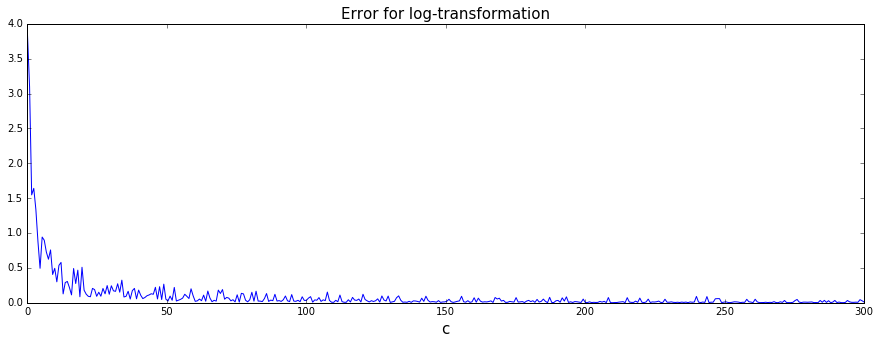

In [128]:
log_errs = np.zeros(len(consts))
for i in range(len(log_errs)):
    log_errs[i] = LogError(data, 0.9, consts[i])

PlotError(log_errs, 'Error for log-transformation')

Теперь буду обучаться на $log(area + c)$, а затем переводить предсказанные значения в "нормальные" единицы измерения $area$ преобразованием ${e^{x} - c}$.

In [129]:
errors = np.zeros(len(consts))
for i in range(len(consts)):
    train, test = Split(data, 0.7)
    train[y_headers] = log(train[y_headers].values + consts[i])
    theta = Fit(train)
    
    prediction = Predict(test[x_headers], theta)
    prediction = exp(prediction) - consts[i]
    errors[i] = msq(test[y_headers], prediction)

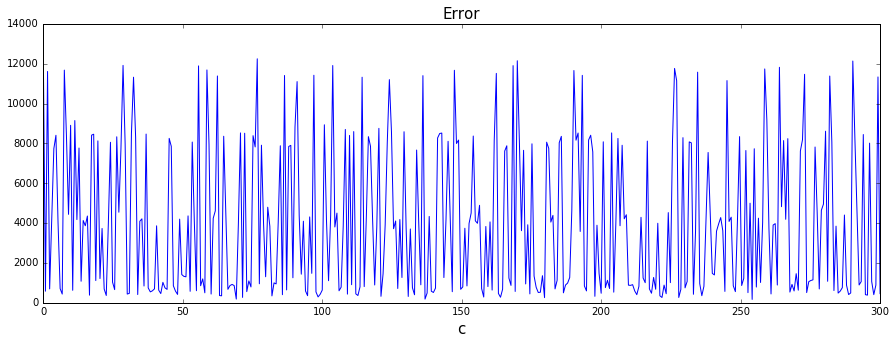

In [130]:
PlotError(errors, 'Error')

"Применяю в последнем случае к оценкам обратное к f преобразование":

In [131]:
errors = np.zeros(len(consts))
for i in range(len(consts)):
    train, test = Split(data, 0.7)
    train[y_headers] = log(train[y_headers].values + consts[i])
    theta = Fit(train)
    theta = exp(theta) - consts[i]
    prediction = Predict(test[x_headers], theta)
    errors[i] = msq(test[y_headers], prediction)

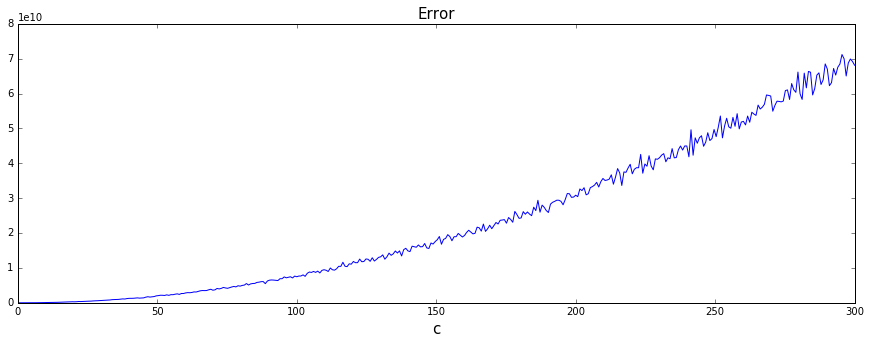

In [132]:
PlotError(errors, 'Error')

14995.3184527 - минимум функции потерь при с = 1


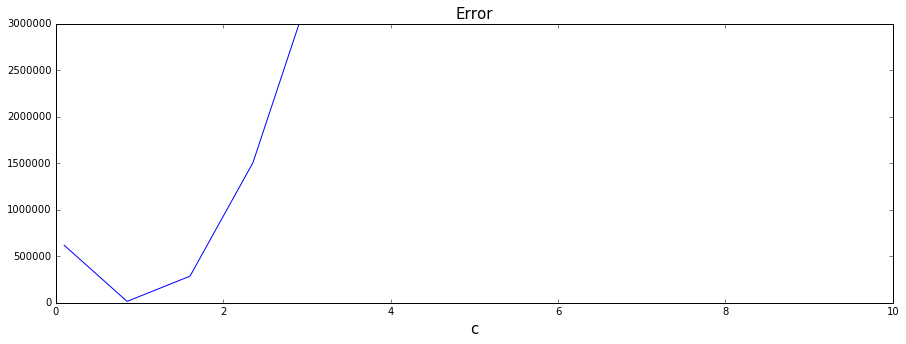

In [138]:
print(str(min(errors))+" - минимум функции потерь при с = 1")
PlotError(errors, 'Error', 10, 3000000)